In [1]:
# import sys
# from importlib import reload
# reload(sys.modules["util.plot"])

import h5py
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from util.path import Path

from himalaya.scoring import correlation_score

from util import plot, subject

# from util.atlas import Atlas
from constants import SUBS_STRANGERS

# import warnings
# warnings.filterwarnings("ignore")

In [2]:
%cd ..

/scratch/gpfs/zzada/fconv


In [3]:
cache = "trialmot6"

# within

In [4]:
corrs = []
corrsP = []
corrsC = []
corrs2 = []
corrs2P = []
corrs2C = []

for subA in tqdm(SUBS_STRANGERS):
    dataA, fwd = subject.get_bold(
        subA,
        return_confounds=["framewise_displacement"],
        use_cache=True,
        cache_desc=cache,
    )
    _, switches = subject.get_button_presses(subA)
    prodmaskA = switches.astype(bool)
    compmaskA = ~prodmaskA

    corrs.append(correlation_score(dataA, fwd))
    corrsP.append(correlation_score(dataA[prodmaskA], fwd[prodmaskA]))
    corrsC.append(correlation_score(dataA[compmaskA], fwd[compmaskA]))

    dataA = subject.get_bold(subA, use_cache=True, cache_desc="nomot")
    corrs2.append(correlation_score(dataA, fwd))
    corrs2P.append(correlation_score(dataA[prodmaskA], fwd[prodmaskA]))
    corrs2C.append(correlation_score(dataA[compmaskA], fwd[compmaskA]))

corrs = np.stack(corrs)
corrsP = np.stack(corrsP)
corrsC = np.stack(corrsC)
corrs2 = np.stack(corrs2)
corrs2P = np.stack(corrs2P)
corrs2C = np.stack(corrs2C)

100%|██████████| 58/58 [05:27<00:00,  5.64s/it]


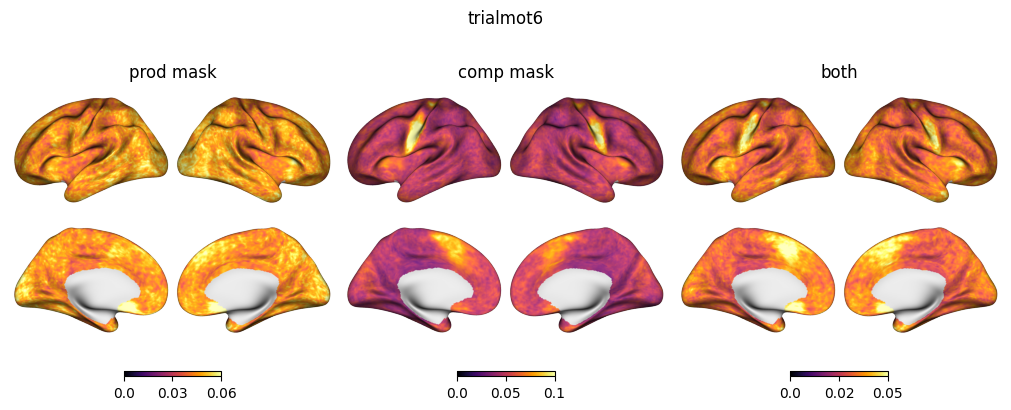

In [5]:
fig, axes = plt.subplots(1, 3, figsize=(10, 4), layout='constrained')
plot.surface_plot(np.abs(corrsP).mean(0), title='prod mask', vmin=0, cmap="inferno", fig=fig, ax=axes[0])
plot.surface_plot(np.abs(corrsC).mean(0), title='comp mask', vmin=0, cmap="inferno", fig=fig, ax=axes[1])
plot.surface_plot(np.abs(corrs).mean(0), title='both', vmin=0, cmap="inferno", fig=fig, ax=axes[2])
fig.suptitle(cache)
fig.show()

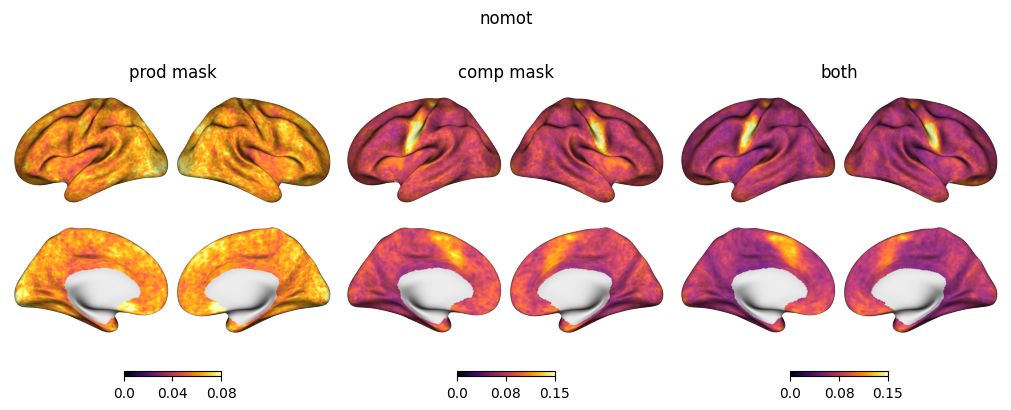

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(10, 4), layout='constrained')
plot.surface_plot(np.abs(corrs2P).mean(0), title='prod mask', vmin=0, cmap="inferno", fig=fig, ax=axes[0])
plot.surface_plot(np.abs(corrs2C).mean(0), title='comp mask', vmin=0, cmap="inferno", fig=fig, ax=axes[1])
plot.surface_plot(np.abs(corrs2).mean(0), title='both', vmin=0, cmap="inferno", fig=fig, ax=axes[2])
fig.suptitle('nomot')
fig.show()

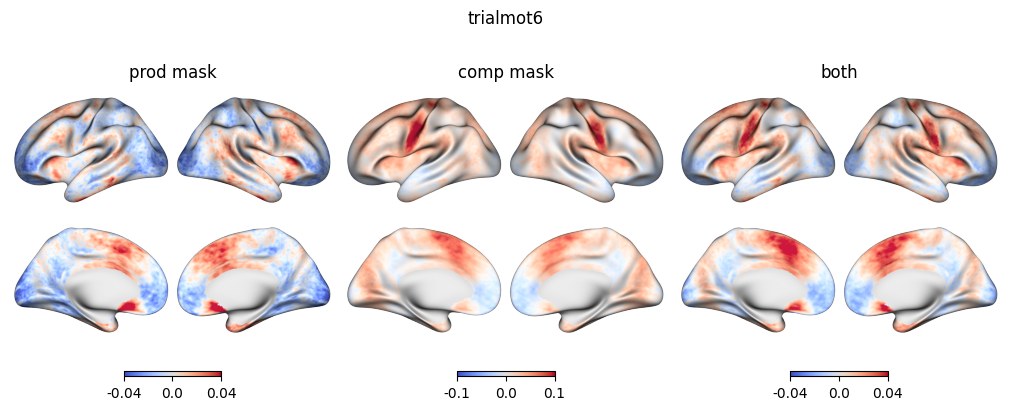

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(10, 4), layout='constrained')
plot.surface_plot(corrsP.mean(0), title='prod mask', fig=fig, ax=axes[0])
plot.surface_plot(corrsC.mean(0), title='comp mask', fig=fig, ax=axes[1])
plot.surface_plot(corrs.mean(0), title='both', fig=fig, ax=axes[2])
fig.suptitle(cache)
fig.show()

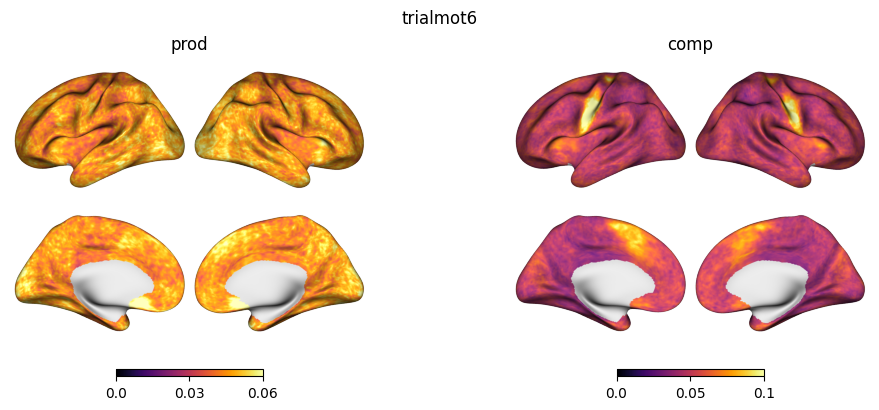

In [49]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), layout='constrained')
plot.surface_plot(np.abs(corrsP).mean(0), title='prod', vmin=0, cmap="inferno", fig=fig, ax=axes[0])
plot.surface_plot(np.abs(corrsC).mean(0), title='comp', vmin=0, cmap="inferno", fig=fig, ax=axes[1])
fig.suptitle(cache)
fig.show()

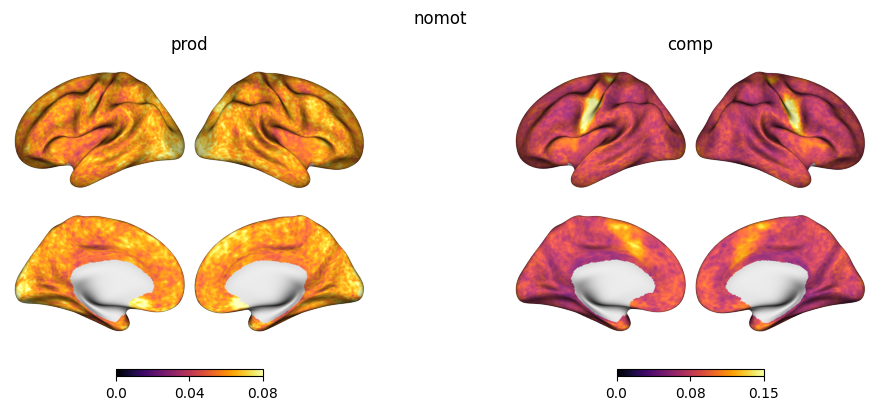

In [47]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), layout="constrained")
plot.surface_plot( np.abs(corrs2P).mean(0), title="prod", vmin=0, cmap="inferno", fig=fig, ax=axes[0])
plot.surface_plot( np.abs(corrs2C).mean(0), title="comp", vmin=0, cmap="inferno", fig=fig, ax=axes[1])
fig.suptitle("nomot")
fig.show()

# intersubject

In [51]:
corrsP = []
corrsC = []
corrsPC = []

for subA in tqdm(SUBS_STRANGERS):
    _, fwd = subject.get_bold(
        subA,
        return_confounds=["framewise_displacement"],
        use_cache=True,
        cache_desc=cache,
    )
    _, switches = subject.get_button_presses(subA)
    prodmaskA = switches.astype(bool)
    compmaskA = ~prodmaskA

    subB = subject.get_partner(subA)
    dataB = subject.get_bold(subB, use_cache=True, cache_desc=cache)
    corrsP.append(correlation_score(dataB[prodmaskA], fwd[prodmaskA]))
    corrsC.append(correlation_score(dataB[compmaskA], fwd[compmaskA]))
    corrsPC.append(correlation_score(dataB, fwd))

corrsP = np.stack(corrsP)
corrsC = np.stack(corrsC)
corrsPC = np.stack(corrsPC)

100%|██████████| 58/58 [02:51<00:00,  2.96s/it]


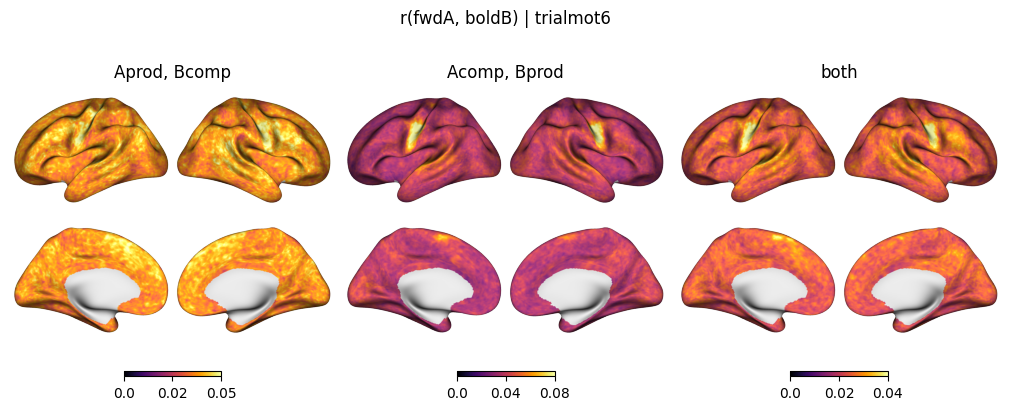

In [56]:
fig, axes = plt.subplots(1, 3, figsize=(10, 4), layout='constrained')
plot.surface_plot(np.abs(corrsP).mean(0), title='Aprod, Bcomp', vmin=0, cmap="inferno", fig=fig, ax=axes[0])
plot.surface_plot(np.abs(corrsC).mean(0), title='Acomp, Bprod', vmin=0, cmap="inferno", fig=fig, ax=axes[1])
plot.surface_plot(np.abs(corrsPC).mean(0), title='both', vmin=0, cmap="inferno", fig=fig, ax=axes[2])
fig.suptitle('r(fwdA, boldB) | ' + cache)
fig.show()

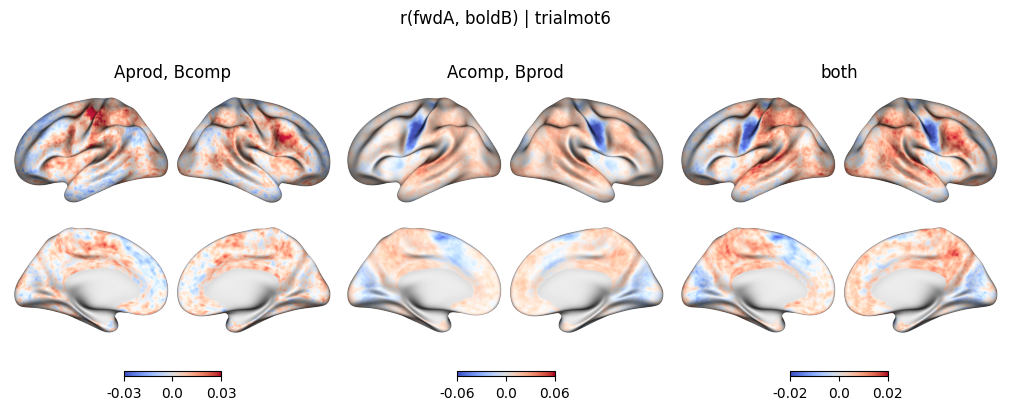

In [57]:
fig, axes = plt.subplots(1, 3, figsize=(10, 4), layout='constrained')
plot.surface_plot(corrsP.mean(0), title='Aprod, Bcomp', fig=fig, ax=axes[0])
plot.surface_plot(corrsC.mean(0), title='Acomp, Bprod', fig=fig, ax=axes[1])
plot.surface_plot(corrsPC.mean(0), title='both', fig=fig, ax=axes[2])
fig.suptitle('r(fwdA, boldB) | ' + cache)
fig.show()